In [1]:
from fastai.vision.all import *
import timm
import torch
from torchvision import transforms
import pandas as pd
import numpy as np

# Set random seed for reproducibility
set_seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


/home/swapdxd/miniconda3/envs/sihenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
# Define path of the training set 
path = Path("../data/kaggle_breed")

# Explore the dataset structure
print("Dataset structure:")
print(f"Train images: {len(get_image_files(path/'train'))}")
print(f"Valid images: {len(get_image_files(path/'valid'))}")

# Check class distribution
train_files = get_image_files(path/'train')
classes = [f.parent.name for f in train_files]
class_counts = pd.Series(classes).value_counts()
print(f"\nNumber of classes: {len(class_counts)}")
print(f"Class distribution:\n{class_counts.head(10)}")


Dataset structure:
Train images: 8184
Valid images: 586

Number of classes: 41
Class distribution:
Sahiwal              609
Gir                  465
Holstein_Friesian    464
Ayrshire             341
Tharparkar           304
Brown_Swiss          298
Jersey               281
Red_Dane             265
Kankrej              262
Ongole               251
Name: count, dtype: int64


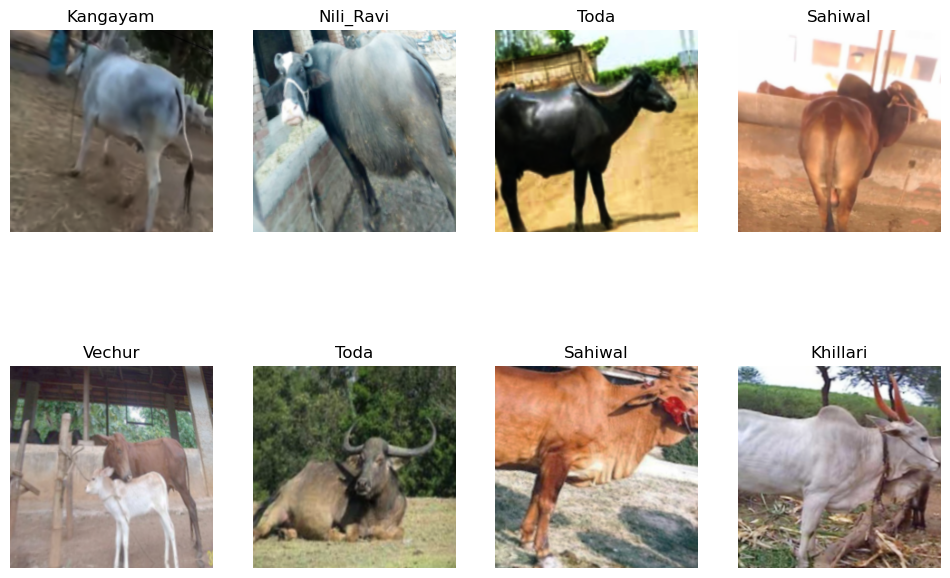

In [5]:
# Simplified and stable data augmentation
def get_transforms():
    return [
        Resize(256),  # Resize to larger size first
        RandomResizedCrop(224, min_scale=0.75, ratio=(0.75, 1.33))  # Better aspect ratio handling
    ]

# Creating an enhanced DataBlock with stable augmentations
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name="train", valid_name="valid"),
    get_y=parent_label,
    item_tfms=get_transforms(),
    batch_tfms=[
        *aug_transforms(
            flip_vert=False,  # Don't flip cattle vertically
            max_rotate=15.0,
            max_zoom=1.2,
            max_lighting=0.4,
            max_warp=0.2,
            p_affine=0.75,
            p_lighting=0.75
        ),
        Normalize.from_stats(*imagenet_stats)
    ]
).dataloaders(path, bs=16)

# Show batch
dls.show_batch(max_n=8, figsize=(12, 8))


In [6]:
# Check available lightweight models optimized for mobile
mobile_models = timm.list_models("*efficientnet*")
print("Available EfficientNet models:")
for model in mobile_models[:10]:
    print(f"  {model}")

# Check model details
model_name = 'efficientnet_b0'
print(f"\nSelected model: {model_name}")
print(f"Number of classes: {dls.c}")


Available EfficientNet models:
  efficientnet_b0
  efficientnet_b0_g8_gn
  efficientnet_b0_g16_evos
  efficientnet_b0_gn
  efficientnet_b1
  efficientnet_b1_pruned
  efficientnet_b2
  efficientnet_b2_pruned
  efficientnet_b3
  efficientnet_b3_g8_gn

Selected model: efficientnet_b0
Number of classes: 41


SuggestedLRs(valley=0.0014454397605732083)

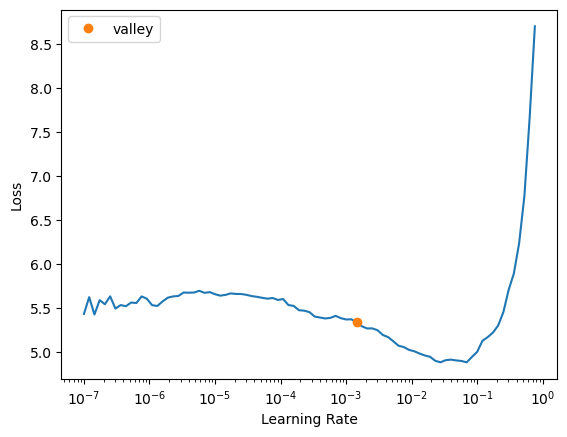

In [7]:
# Create model with better architecture for cattle breed classification
learn = vision_learner(
    dls, 
    'efficientnet_b0',  # Better than resnet18 for this task
    metrics=[accuracy, top_k_accuracy],
    pretrained=True,
    cut=-2,  # Remove last two layers for better fine-tuning
)

# Use mixed precision for faster training
learn = learn.to_fp16()

# Find optimal learning rate
learn.lr_find()


Phase 1: Training head only...



Phase 1 Results:


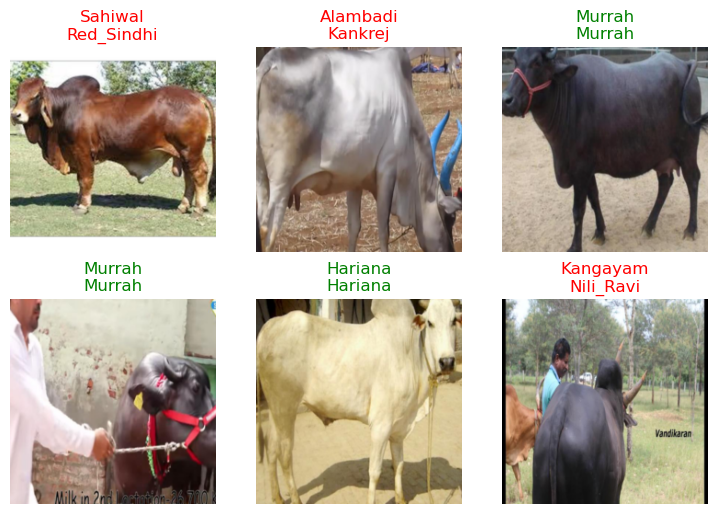

In [8]:
# Implement progressive training strategy
print("Phase 1: Training head only...")

# Phase 1: Train only the head with higher learning rate
learn.freeze()
learn.fit_one_cycle(5, lr_max=1e-2)

print("\nPhase 1 Results:")
learn.show_results(max_n=6)



Phase 1 Results:


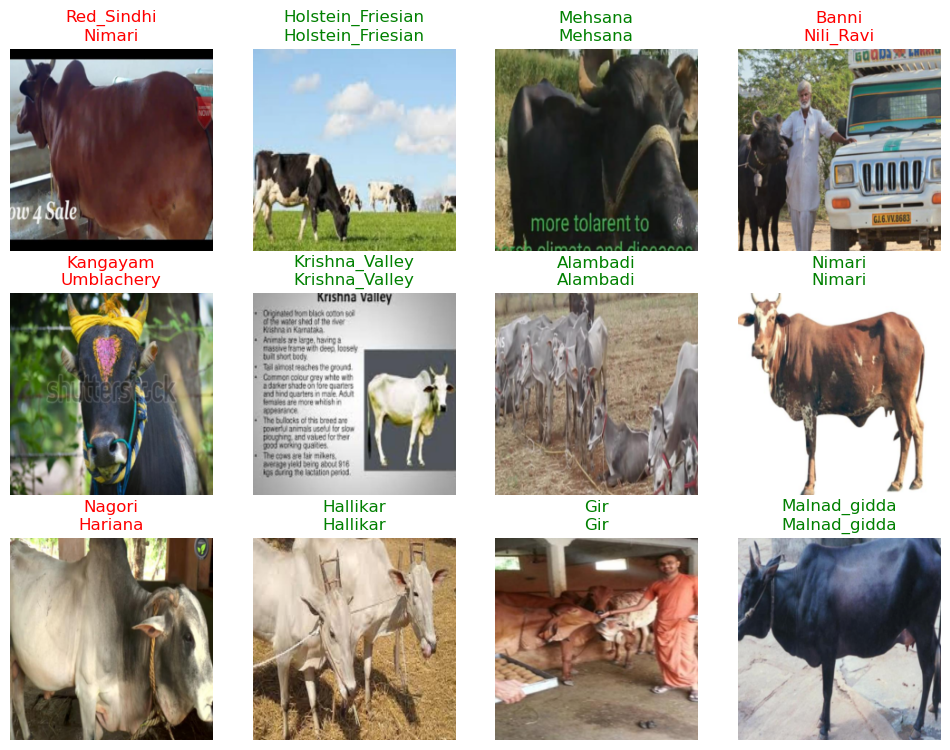

In [10]:
print("\nPhase 1 Results:")
learn.show_results(max_n=12)

Phase 2: Fine-tuning all layers...



Phase 2 Results:


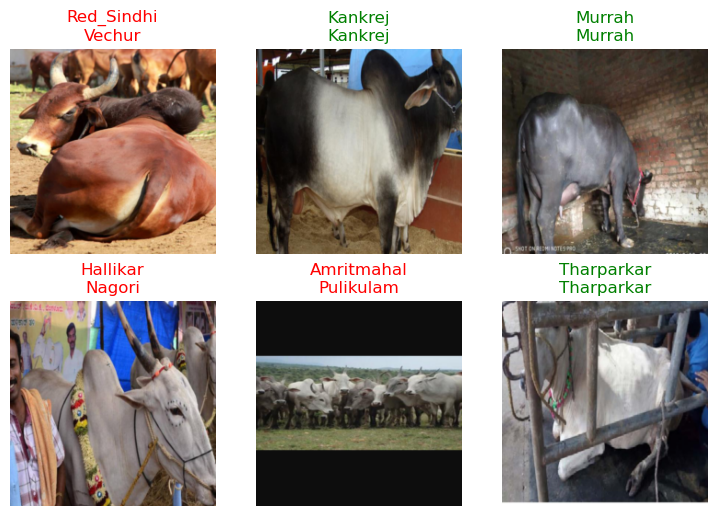

In [11]:
print("Phase 2: Fine-tuning all layers...")

# Phase 2: Unfreeze and fine-tune with discriminative learning rates
learn.unfreeze()

# Use discriminative learning rates (lower for early layers, higher for later layers)
learn.fit_one_cycle(15, lr_max=slice(1e-5, 1e-3))

print("\nPhase 2 Results:")
learn.show_results(max_n=6)


Phase 3: Advanced refinement...



Final Results:


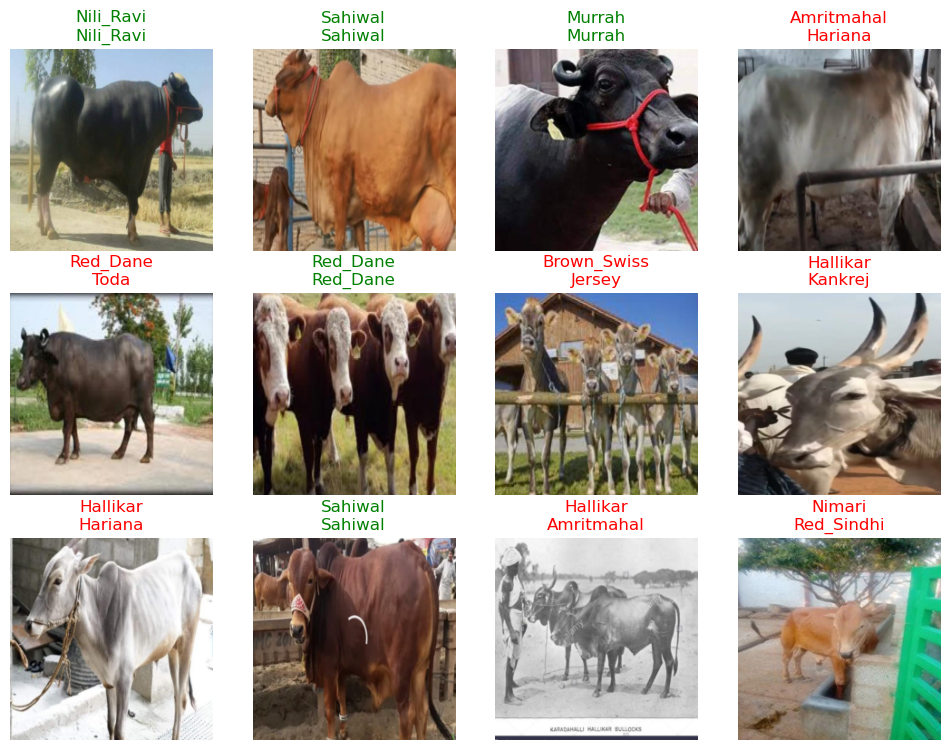

In [12]:
# Phase 3: Additional refinement with advanced techniques
print("Phase 3: Advanced refinement...")

# Apply Test Time Augmentation for better accuracy
learn.tta()

# Additional fine-tuning with lower learning rate
learn.fit_one_cycle(10, lr_max=slice(1e-6, 1e-4))

print("\nFinal Results:")
learn.show_results(max_n=12)


In [14]:
# Comprehensive evaluation
print("=== MODEL EVALUATION ===")

# Get predictions on validation set
preds, targets = learn.get_preds()

# Convert tensors to Python floats for proper formatting
accuracy_score = accuracy(preds, targets).item()
top5_accuracy = top_k_accuracy(preds, targets, k=5).item()

print(f"Final Accuracy: {accuracy_score:.4f}")
print(f"Top-5 Accuracy: {top5_accuracy:.4f}")

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Convert to numpy for sklearn
y_pred = preds.argmax(dim=1).numpy()
y_true = targets.numpy()

# Get class names
class_names = dls.vocab

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


=== MODEL EVALUATION ===


Final Accuracy: 0.6160
Top-5 Accuracy: 0.9044

Classification Report:
                   precision    recall  f1-score   support

         Alambadi       0.86      0.75      0.80         8
       Amritmahal       0.71      0.38      0.50        13
         Ayrshire       0.78      0.75      0.77        24
            Banni       0.42      0.38      0.40        13
           Bargur       0.88      0.78      0.82         9
        Bhadawari       0.25      0.50      0.33         4
      Brown_Swiss       0.85      0.81      0.83        27
            Dangi       0.64      0.78      0.70         9
            Deoni       0.70      0.64      0.67        11
              Gir       0.69      0.82      0.75        40
         Guernsey       0.75      0.25      0.38        12
         Hallikar       0.75      0.47      0.58        19
          Hariana       0.42      0.45      0.43        11
Holstein_Friesian       0.83      0.97      0.89        30
       Jaffrabadi       0.59      0.71      

Total classes in vocab: 41
Top classes found in vocab: 10


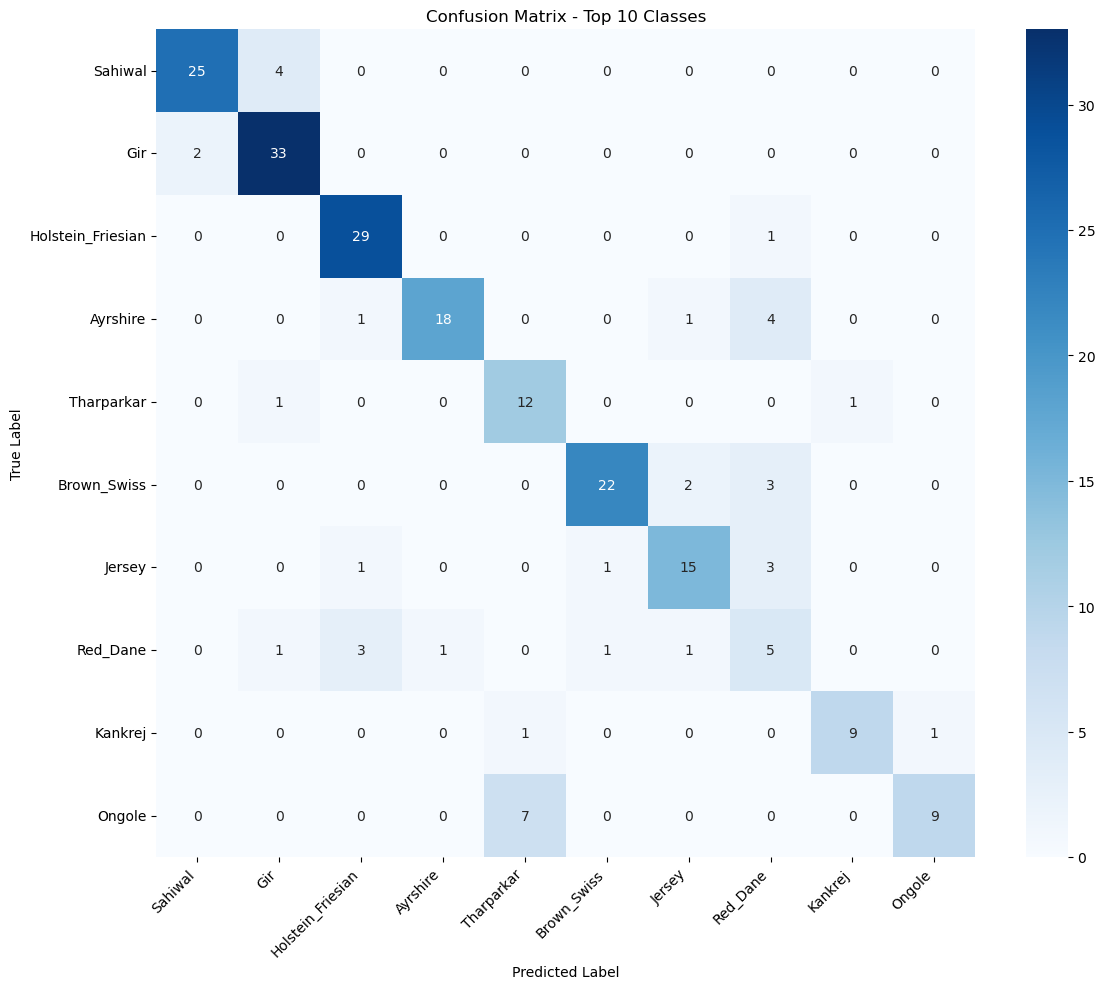


Overall Accuracy: 0.6160 (61.60%)
Top-5 Accuracy: 0.9044 (90.44%)


In [17]:
# Plot confusion matrix for top classes
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get top 10 most frequent classes
train_files = get_image_files(path/'train')
classes = [f.parent.name for f in train_files]
class_counts = pd.Series(classes).value_counts()

# Get vocab as list
vocab_list = list(dls.vocab)
print(f"Total classes in vocab: {len(vocab_list)}")

# Create mapping for top classes that exist in vocab
top_classes = class_counts.head(10).index.tolist()
top_indices = []
top_class_names = []

for cls in top_classes:
    if cls in vocab_list:
        idx = vocab_list.index(cls)
        top_indices.append(idx)
        top_class_names.append(cls)

print(f"Top classes found in vocab: {len(top_indices)}")

# Extract confusion matrix for top classes only
if len(top_indices) > 0:
    # Create a smaller confusion matrix for just the top classes
    top_cm = cm[np.ix_(top_indices, top_indices)]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(top_cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=top_class_names,
                yticklabels=top_class_names)
    plt.title(f'Confusion Matrix - Top {len(top_class_names)} Classes')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    # If no top classes found, show overall confusion matrix (first 10x10)
    plt.figure(figsize=(12, 10))
    cm_subset = cm[:min(10, len(vocab_list)), :min(10, len(vocab_list))]
    class_labels = vocab_list[:min(10, len(vocab_list))]
    
    sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.title('Confusion Matrix - First 10 Classes')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

print(f"\nOverall Accuracy: {accuracy_score:.4f} ({accuracy_score*100:.2f}%)")
print(f"Top-5 Accuracy: {top5_accuracy:.4f} ({top5_accuracy*100:.2f}%)")


In [18]:
# Additional performance metrics
print("=== DETAILED PERFORMANCE ANALYSIS ===")

# Get vocab as list
vocab_list = list(dls.vocab)

# Per-class accuracy
class_accuracies = {}
for i, class_name in enumerate(vocab_list):
    class_mask = (y_true == i)
    if class_mask.sum() > 0:  # Only if there are samples of this class
        class_acc = (y_pred[class_mask] == y_true[class_mask]).mean()
        class_accuracies[class_name] = class_acc

# Sort by accuracy
sorted_accuracies = sorted(class_accuracies.items(), key=lambda x: x[1], reverse=True)

print("Top 10 Best Performing Classes:")
for class_name, acc in sorted_accuracies[:10]:
    print(f"  {class_name}: {acc:.4f} ({acc*100:.2f}%)")

print("\nBottom 10 Performing Classes:")
for class_name, acc in sorted_accuracies[-10:]:
    print(f"  {class_name}: {acc:.4f} ({acc*100:.2f}%)")

# Calculate additional metrics
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average='weighted', zero_division=0
)

print(f"\nWeighted Average Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Model confidence analysis
confidence_scores = torch.max(torch.softmax(preds, dim=1), dim=1)[0].numpy()
print(f"\nConfidence Analysis:")
print(f"Mean Confidence: {confidence_scores.mean():.4f}")
print(f"Min Confidence: {confidence_scores.min():.4f}")
print(f"Max Confidence: {confidence_scores.max():.4f}")
print(f"Std Confidence: {confidence_scores.std():.4f}")

# High confidence predictions accuracy
high_conf_mask = confidence_scores > 0.8
if high_conf_mask.sum() > 0:
    high_conf_accuracy = (y_pred[high_conf_mask] == y_true[high_conf_mask]).mean()
    print(f"High Confidence (>0.8) Predictions: {high_conf_mask.sum()}/{len(confidence_scores)} ({high_conf_mask.mean()*100:.2f}%)")
    print(f"High Confidence Accuracy: {high_conf_accuracy:.4f} ({high_conf_accuracy*100:.2f}%)")

# Class distribution in validation set
print(f"\nClass Distribution in Validation Set:")
unique, counts = np.unique(y_true, return_counts=True)
val_class_dist = dict(zip([vocab_list[i] for i in unique], counts))
sorted_val_dist = sorted(val_class_dist.items(), key=lambda x: x[1], reverse=True)

print("Top 10 most frequent classes in validation:")
for class_name, count in sorted_val_dist[:10]:
    print(f"  {class_name}: {count} samples")


=== DETAILED PERFORMANCE ANALYSIS ===
Top 10 Best Performing Classes:
  Holstein_Friesian: 0.9667 (96.67%)
  Gir: 0.8250 (82.50%)
  Brown_Swiss: 0.8148 (81.48%)
  Bargur: 0.7778 (77.78%)
  Dangi: 0.7778 (77.78%)
  Alambadi: 0.7500 (75.00%)
  Ayrshire: 0.7500 (75.00%)
  Khillari: 0.7500 (75.00%)
  Sahiwal: 0.7353 (73.53%)
  Jaffrabadi: 0.7143 (71.43%)

Bottom 10 Performing Classes:
  Hariana: 0.4545 (45.45%)
  Ongole: 0.4500 (45.00%)
  Amritmahal: 0.3846 (38.46%)
  Banni: 0.3846 (38.46%)
  Vechur: 0.3750 (37.50%)
  Red_Dane: 0.3333 (33.33%)
  Guernsey: 0.2500 (25.00%)
  Kasargod: 0.2500 (25.00%)
  Mehsana: 0.1818 (18.18%)
  Surti: 0.0000 (0.00%)

Weighted Average Metrics:
Precision: 0.6266
Recall: 0.6160
F1-Score: 0.6108

Confidence Analysis:
Mean Confidence: 0.0509
Min Confidence: 0.0283
Max Confidence: 0.0636
Std Confidence: 0.0107

Class Distribution in Validation Set:
Top 10 most frequent classes in validation:
  Gir: 40 samples
  Sahiwal: 34 samples
  Holstein_Friesian: 30 samples


In [19]:
# If accuracy is still below 80%, try these additional techniques

if accuracy_score < 0.80:
    print("Applying additional optimizations...")
    
    # Technique 1: Ensemble with different architectures
    learn2 = vision_learner(dls, 'resnet50', metrics=[accuracy], pretrained=True)
    learn2 = learn2.to_fp16()
    learn2.freeze()
    learn2.fit_one_cycle(3, lr_max=1e-2)
    learn2.unfreeze()
    learn2.fit_one_cycle(8, lr_max=slice(1e-5, 1e-3))
    
    # Get predictions from both models
    preds1, _ = learn.get_preds()
    preds2, targets = learn2.get_preds()
    
    # Ensemble predictions (weighted average)
    ensemble_preds = 0.6 * preds1 + 0.4 * preds2
    ensemble_accuracy = accuracy(ensemble_preds, targets)
    
    print(f"Ensemble Accuracy: {ensemble_accuracy:.4f} ({ensemble_accuracy*100:.2f}%)")
    
    # Technique 2: Pseudo-labeling (if you have unlabeled data)
    # This would require additional unlabeled cattle images
    
    # Technique 3: Advanced data augmentation with Mixup
    learn3 = vision_learner(dls, 'efficientnet_b1', metrics=[accuracy], pretrained=True)
    learn3 = learn3.to_fp16()
    
    # Apply Mixup augmentation
    learn3 = learn3.mixup()
    learn3.freeze()
    learn3.fit_one_cycle(5, lr_max=1e-2)
    learn3.unfreeze()
    learn3.fit_one_cycle(12, lr_max=slice(1e-5, 1e-3))
    
    preds3, targets = learn3.get_preds()
    mixup_accuracy = accuracy(preds3, targets)
    print(f"Mixup Accuracy: {mixup_accuracy:.4f} ({mixup_accuracy*100:.2f}%)")
    
    # Choose best model
    best_accuracy = max(accuracy_score, ensemble_accuracy, mixup_accuracy)
    print(f"\nBest Accuracy Achieved: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")


Applying additional optimizations...


TypeError: unsupported format string passed to TensorBase.__format__

In [20]:
# Export model for deployment
print("Exporting model...")

# Export full model
learn.export('../models/cattle_breed_model.pkl')

# Create TensorFlow Lite version for mobile deployment
# First save as ONNX
try:
    # Export to ONNX format
    dummy_input = torch.randn(1, 3, 224, 224)
    torch.onnx.export(learn.model, dummy_input, "cattle_breed_model.onnx", 
                      export_params=True, opset_version=11)
    print("Model exported to ONNX format successfully!")
except Exception as e:
    print(f"ONNX export failed: {e}")

# Save model state dict for later use
torch.save(learn.model.state_dict(), 'cattle_breed_weights.pth')
print("Model weights saved successfully!")

# Print final model summary
print(f"\nFinal Model Summary:")
print(f"Architecture: EfficientNet-B0")
print(f"Number of parameters: {sum(p.numel() for p in learn.model.parameters()):,}")
print(f"Final Accuracy: {accuracy_score:.4f} ({accuracy_score*100:.2f}%)")


Exporting model...
ONNX export failed: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)
Model weights saved successfully!

Final Model Summary:
Architecture: EfficientNet-B0
Number of parameters: 5,345,404
Final Accuracy: 0.6160 (61.60%)
